In [3]:
####防止内核重启####
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
###放在第一位###

In [22]:
import os
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


label_dict = {"monkey": 0, "fox": 1, "elephant": 2}
class_dict = {0: "monkey", 1: "fox", 2: "elephant"}
N = 3 

class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label

    def __len__(self):
        return len(self.data)


def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader



In [13]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)

class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

In [24]:
train()

data processing...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Training...


  3%|##7                                                                                | 1/30 [00:05<02:25,  5.02s/it]

Epoch 000 train_loss 0.68971 val_loss 0.70859


  7%|#####5                                                                             | 2/30 [00:10<02:21,  5.05s/it]

Epoch 001 train_loss 0.66893 val_loss 0.72885


 10%|########3                                                                          | 3/30 [00:15<02:17,  5.10s/it]

Epoch 002 train_loss 0.64521 val_loss 0.72516


 13%|###########                                                                        | 4/30 [00:20<02:11,  5.05s/it]

Epoch 003 train_loss 0.61849 val_loss 0.60768


 17%|#############8                                                                     | 5/30 [00:25<02:05,  5.02s/it]

Epoch 004 train_loss 0.59623 val_loss 0.61109


 20%|################6                                                                  | 6/30 [00:30<02:00,  5.03s/it]

Epoch 005 train_loss 0.57386 val_loss 0.60039


 23%|###################3                                                               | 7/30 [00:35<01:55,  5.02s/it]

Epoch 006 train_loss 0.54266 val_loss 0.55222


 27%|######################1                                                            | 8/30 [00:40<01:50,  5.01s/it]

Epoch 007 train_loss 0.54394 val_loss 0.62406


 30%|########################9                                                          | 9/30 [00:45<01:44,  5.00s/it]

Epoch 008 train_loss 0.52579 val_loss 0.58255


 33%|###########################3                                                      | 10/30 [00:50<01:41,  5.10s/it]

Epoch 009 train_loss 0.51832 val_loss 0.55364


 37%|##############################                                                    | 11/30 [00:55<01:36,  5.08s/it]

Epoch 010 train_loss 0.49651 val_loss 0.63108


 40%|################################8                                                 | 12/30 [01:00<01:31,  5.11s/it]

Epoch 011 train_loss 0.48868 val_loss 0.54007


 43%|###################################5                                              | 13/30 [01:05<01:26,  5.11s/it]

Epoch 012 train_loss 0.48575 val_loss 0.52053


 47%|######################################2                                           | 14/30 [01:10<01:21,  5.11s/it]

Epoch 013 train_loss 0.46654 val_loss 0.57047


 50%|#########################################                                         | 15/30 [01:16<01:16,  5.10s/it]

Epoch 014 train_loss 0.45445 val_loss 0.54755


 53%|###########################################7                                      | 16/30 [01:21<01:11,  5.10s/it]

Epoch 015 train_loss 0.46787 val_loss 0.57985


 57%|##############################################4                                   | 17/30 [01:26<01:05,  5.06s/it]

Epoch 016 train_loss 0.45395 val_loss 0.55991


 60%|#################################################1                                | 18/30 [01:31<01:00,  5.05s/it]

Epoch 017 train_loss 0.44553 val_loss 0.60963


 63%|###################################################9                              | 19/30 [01:36<00:55,  5.06s/it]

Epoch 018 train_loss 0.43191 val_loss 0.55302


 67%|######################################################6                           | 20/30 [01:41<00:50,  5.06s/it]

Epoch 019 train_loss 0.43619 val_loss 0.52383


 70%|#########################################################4                        | 21/30 [01:46<00:45,  5.05s/it]

Epoch 020 train_loss 0.43588 val_loss 0.63879


 73%|############################################################1                     | 22/30 [01:51<00:40,  5.05s/it]

Epoch 021 train_loss 0.42275 val_loss 0.52372


 77%|##############################################################8                   | 23/30 [01:56<00:35,  5.06s/it]

Epoch 022 train_loss 0.41151 val_loss 0.55405


 80%|#################################################################6                | 24/30 [02:01<00:30,  5.06s/it]

Epoch 023 train_loss 0.41282 val_loss 0.54612


 83%|####################################################################3             | 25/30 [02:06<00:25,  5.06s/it]

Epoch 024 train_loss 0.40672 val_loss 0.53595


 87%|#######################################################################           | 26/30 [02:11<00:20,  5.06s/it]

Epoch 025 train_loss 0.40699 val_loss 0.52924


 90%|#########################################################################8        | 27/30 [02:16<00:15,  5.07s/it]

Epoch 026 train_loss 0.40149 val_loss 0.59598


 93%|############################################################################5     | 28/30 [02:21<00:10,  5.06s/it]

Epoch 027 train_loss 0.40738 val_loss 0.52507


 97%|###############################################################################2  | 29/30 [02:26<00:05,  5.06s/it]

Epoch 028 train_loss 0.39538 val_loss 0.54502


100%|##################################################################################| 30/30 [02:31<00:00,  5.07s/it]
2024-11-22 10:30:44.006 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 155.80449151992798 s


Epoch 029 train_loss 0.40324 val_loss 0.55505


In [25]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [26]:
test()

data processing...


2024-11-22 10:30:54.750 | DEBUG    | classify.decorator:wrapper:13 - test运行时间: 7.330739498138428 s


Accuracy: 83.20%


In [10]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

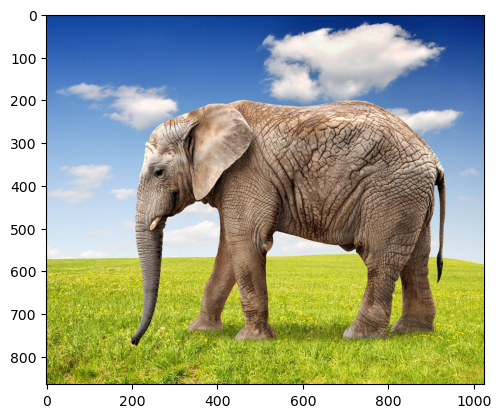

In [29]:
import unittest
from PIL import Image
import torch
from matplotlib import pyplot as plt
from torchvision import transforms

from classify.cnn import cnn
from classify.data_process import class_dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl", map_location=device), strict=False)
model.eval()

_img_path = r"C:\Users\86134\Desktop\大作业\data\elephant\elephant.jpg"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # 标准化
])

img = Image.open(_img_path).convert('RGB')
img_transform = transform(img).unsqueeze(0).to(device) 

output = model(img_transform)

_, predicted = torch.max(output, 1)

predicted_class = class_dict[predicted.item()]

print(f"Predicted class: {predicted_class}, Output: {output}")

plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.show()


In [14]:
np.log(0.5)

-0.6931471805599453

In [17]:
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

elephant


In [20]:
import torch
torch.__version__

'2.4.1+cpu'